<a href="https://colab.research.google.com/github/victormutuku/Is-Project-II/blob/main/IS_Project_II_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Setup
 - Loadig Libraries

In [ ]:
import json
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw


In [ ]:
%cd drive/MyDrive/repos/Mask_RCNN

/content/drive/MyDrive/repos/Mask_RCNN


In [ ]:
# ! git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 58 kB/s 
     |████████████████████████████████| 276 kB 40.1 MB/s 
     |████████████████████████████████| 2.9 MB 41.4 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 3.2 MB 33.7 MB/s 
     |████████████████████████████████| 367 kB 41.4 MB/s 
     |████████████████████████████████| 1.6 MB 55.1 MB/s 
     |████████████████████████████████| 154 kB 63.4 MB/s 
     |████████████████████████████████| 298 kB 57.1 MB/s 
     |████████████████████████████████| 121 kB 69.6 MB/s 
     |████████████████████████████████| 83 kB 2.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling te

In [ ]:
! python3 setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding licens

In [ ]:
from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
from mrcnn.model import MaskRCNN
from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw


Using TensorFlow backend.


#Defining Functions

In [ ]:

class Dataset(utils.Dataset):
  """ 
  Load the coco-formatted dataset from json

  Args:
      annotation_json: The path to the coco annotations json file
      images_dir:  The directory holding the images referred to by the json file

  """

  # Load json from file
  def load_data(self, annotation_json, images_dir):
    json_file = open(annotation_json)
    coco_json = json.load(json_file)
    json_file.close()

    # Add the class names using the base method from utils.Dataset
    source_name = "coco_like"
    for category in coco_json['categories']:
      class_id = category['id']
      class_name = category['name']
      if class_id < 1:
        print('Erorr: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
        return

      self.add_class(source_name, class_id, class_name)

    # Get all annotations
    annotations = {}
    for annotation in coco_json['annotations']:
      image_id = annotation['image_id']
      if image_id not in annotations:
        annotations[image_id] = []
      annotations[image_id].append(annotation)

    # Get all images and add them to the dataset
    seen_images = {}
    for image in coco_json['images']:
      image_id = image['id']
      if image_id in seen_images:
        print("Warning: Skipping duplicate image id: {}", format(image))
      else:
        seen_images[image_id] = image
        try:
          image_file_name = image['file_name']
          image_width = image['width']
          image_height = image['height']
        except KeyError as key:
          print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

        image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
        image_annotations = annotations[image_id]

        # Add the image using the base method from utils.Dataset
        self.add_image(
            source = source_name,
            image_id = image_id,
            path = image_path,
            width = image_width,
            height = image_height,
            annotations = image_annotations
        )
  def load_mask(self, image_id):
    """ Load instnace masks for the given image.
    MaskRCNN expects masks in th eform of a bitmap [height, width, instances].
    Args:
        image_id: The id of the image to load masks for
    Returns:
        masks: A bool array of the shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of theinstance masks.
    """

    image_info = self.image_info[image_id]
    annotations = image_info['annotations']
    instance_masks = []
    class_ids = []

    for annotation in  annotations:
      class_id = annotation['category_id']
      mask = Image.new('1', (image_info['width'], image_info['height']))
      mask_draw = ImageDraw.ImageDraw(mask, '1')
      for segmentation in annotation['segmentation']:
        mask_draw.polygon(segmentation, fill=1)
        bool_array = np.array(mask) > 0
        instance_masks.append(bool_array)
        class_ids.append(class_id)

    mask = np.dstack(instance_masks)
    class_ids = np.array(class_ids, dtype=np.int32)

    return mask, class_ids



#Data Preprocessing

In [ ]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
os.getcwd()

'/content/drive/MyDrive/repos'

In [ ]:
# splitfolders.ratio(input='dataset_split', output='dataset_split/splitted_dataset', seed=2, ratio=(.7, .2, .1), group_prefix=None)

#Creating SubFolders

In [ ]:
jsonfile = 'dataset_split/_annotations.coco.json'

##Training

In [ ]:
print(os.getcwd())

/content/drive/MyDrive/repos/Mask_RCNN


In [ ]:
TRAINING_DIR = os.path.abspath("./dataset_split/splitted_dataset/train")
# Change working directory
os.chdir(TRAINING_DIR)

In [ ]:
# Path to the original annotations file
initialjson = os.path.abspath('../../_annotations.coco.json')

# Path to the training folder
traindir = os.path.abspath('./dataset')

# Variable trainfiles holds alist of all the file names in traindir
trainfiles = os.listdir(traindir)

# print(trainfiles)

myfile = open(initialjson)
myopenfile = json.load(myfile)

countnf = 0
tobecopied = []

for image in myopenfile['images']:
  imagefname = image['file_name']
  # print(image)

  for trainfile in trainfiles:
    if(imagefname == trainfile):
      tobecopied.append(image)
    else:
      # print("Not found")
      countnf += 1

# print("Found: ", countf)
print("Total Not Found: ", countnf)
print(tobecopied)

with open('training_annotations.json', 'w') as trainannot:
  json.dump(tobecopied, trainannot)    




In [ ]:
trainjsonfile = json.load(open('training_annotations.json'))
annot = []
for image in myopenfile['annotations']:
  imageId = image['image_id']
  
  for trainjson in trainjsonfile['images']:
    trainjsonid = trainjson['id']
    # print(image)
    if(imageId == trainjsonid):
      annot.append(image)

print(annot)

with open('new_training_annotations.json', 'w') as trainannot:
  json.dump(annot, trainannot)  

##Validation

In [ ]:
print(os.getcwd())

/content/drive/MyDrive/repos/Mask_RCNN/dataset_split/splitted_dataset/val


In [ ]:
VALIDATION_DIR = os.path.abspath("../val")
os.chdir(VALIDATION_DIR)

In [ ]:
# Path to the original annotations file
initialjson = os.path.abspath('../../_annotations.coco.json')

# Path to the training folder
valdir = os.path.abspath('./dataset')

# Variable trainfiles holds alist of all the file names in traindir
valfiles = os.listdir(valdir)

# print(trainfiles)

myfile = open(initialjson)
myopenfile = json.load(myfile)

countnf = 0
tobecopied = []

for image in myopenfile['images']:
  imagefname = image['file_name']
  # print(image)

  for valfile in valfiles:
    if(imagefname == valfile):
      tobecopied.append(image)
    else:
      # print("Not found")
      countnf += 1

# print("Found: ", countf)
print("Total Not Found: ", countnf)
print(tobecopied)

with open('val_annotations.json', 'w') as valannot:
  json.dump(tobecopied, valannot) 

Total Not Found:  40410
[{'id': 5, 'license': 1, 'file_name': 'book88_jpg.rf.97e5bb588628f9747baf0da1e8915797.jpg', 'height': 600, 'width': 600, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 8, 'license': 1, 'file_name': '1513893130-motivational-books_jpg.rf.9cb9fba0c0a0cc462cd715912546606d.jpg', 'height': 1000, 'width': 2000, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 11, 'license': 1, 'file_name': 'book55_jpg.rf.a00dc72f7bfe93740003d55d5e40465e.jpg', 'height': 640, 'width': 640, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 17, 'license': 1, 'file_name': 'book104_jpg.rf.974bfecd8b74bcc0203f2c8cf7ab7085.jpg', 'height': 244, 'width': 244, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 24, 'license': 1, 'file_name': 'book53_jpg.rf.999821936165f7a2bcda75ce94bb1f0a.jpg', 'height': 800, 'width': 1200, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 34, 'license': 1, 'file_name': 'book81_jpg.rf.a30c957cd8e4fdd9437ceeb67104498a.jpg', 'height': 225, 'wi

In [ ]:
valjsonfile = json.load(open('val_annotations.json'))
annot = []
for image in myopenfile['annotations']:
  imageId = image['image_id']
  
  for valjson in valjsonfile['images']:
    valjsonid = valjson['id']
    # print(image)
    if(imageId == valjsonid):
      annot.append(image)

print(annot)

with open('new_val_annotations.json', 'w') as valannot:
  json.dump(annot, valannot) 

[{'id': 6, 'image_id': 5, 'category_id': 1, 'bbox': [134, 24, 351.57, 498.454], 'area': 175241.667, 'segmentation': [[469.488, 24.228, 134.491, 47.653, 152.071, 522.682, 486.061, 498.831, 469.488, 24.228]], 'iscrowd': 0}, {'id': 18, 'image_id': 8, 'category_id': 1, 'bbox': [0, 380, 358.981, 470.549], 'area': 168918.183, 'segmentation': [], 'iscrowd': 0}, {'id': 19, 'image_id': 8, 'category_id': 1, 'bbox': [310, 450, 428.386, 471.654], 'area': 202050.08, 'segmentation': [], 'iscrowd': 0}, {'id': 20, 'image_id': 8, 'category_id': 1, 'bbox': [693, 525, 427.468, 472.619], 'area': 202029.467, 'segmentation': [], 'iscrowd': 0}, {'id': 21, 'image_id': 8, 'category_id': 1, 'bbox': [1069, 599, 424.999, 400.806], 'area': 170342.037, 'segmentation': [], 'iscrowd': 0}, {'id': 22, 'image_id': 8, 'category_id': 1, 'bbox': [1455, 674, 420.019, 326.327], 'area': 137063.489, 'segmentation': [], 'iscrowd': 0}, {'id': 23, 'image_id': 8, 'category_id': 1, 'bbox': [1561, 213, 426.468, 472.584], 'area': 201

##Testing

In [ ]:
TESTING_DIR = os.path.abspath("../test")
os.chdir(TESTING_DIR)
print(os.getcwd())

FileNotFoundError: ignored

In [ ]:
# Path to the original annotations file
initialjson = os.path.abspath('../../_annotations.coco.json')

# Path to the training folder
testdir = os.path.abspath('./dataset')

# Variable trainfiles holds alist of all the file names in traindir
testfiles = os.listdir(testdir)

# print(trainfiles)

myfile = open(initialjson)
myopenfile = json.load(myfile)

countnf = 0
tobecopied = []

for image in myopenfile['images']:
  imagefname = image['file_name']
  # print(image)

  for testfile in testfiles:
    if(imagefname == testfile):
      tobecopied.append(image)
    else:
      # print("Not found")
      countnf += 1

# print("Found: ", countf)
print("Total Not Found: ", countnf)
print(tobecopied)

with open('test_annotations.json', 'w') as testannot:
  json.dump(tobecopied, testannot) 

Total Not Found:  20654
[{'id': 0, 'license': 1, 'file_name': 'book43_jpg.rf.94a7d8fc2c9798182b77c23b001ad9ea.jpg', 'height': 258, 'width': 169, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 3, 'license': 1, 'file_name': 'book6_jpg.rf.96ac2cd2fca3cf5de87a01338e13de48.jpg', 'height': 320, 'width': 320, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 14, 'license': 1, 'file_name': 'best-childrens-picture-books_png.rf.9cf48f96832c58d34f94cbc998cddd97.jpg', 'height': 417, 'width': 740, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 37, 'license': 1, 'file_name': 'book18_jpg.rf.9d30679d6572ca79bb5484d1868e3fe0.jpg', 'height': 1001, 'width': 1001, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 39, 'license': 1, 'file_name': 'book71_jpg.rf.a811be1e00c803a36c597449dd2918ca.jpg', 'height': 2048, 'width': 2048, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 43, 'license': 1, 'file_name': 'book30_jpg.rf.a8e953195a25e73a2464067e01b8dffc.jpg', 'height': 2048, 'wid

In [ ]:
testjsonfile = json.load(open('test_annotations.json'))
annot = []
for image in myopenfile['annotations']:
  imageId = image['image_id']
  
  for testjson in testjsonfile['images']:
    testjsonid = testjson['id']
    # print(image)
    if(imageId == testjsonid):
      annot.append(image)

print(annot)

with open('new_test_annotations.json', 'w') as testannot:
  json.dump(annot, testannot) 

[{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [0, 0, 169, 258], 'area': 43602, 'segmentation': [], 'iscrowd': 0}, {'id': 4, 'image_id': 3, 'category_id': 1, 'bbox': [53, 5, 219.849, 312.582], 'area': 68720.849, 'segmentation': [[260.786, 5.317, 231.177, 6.252, 53.2, 6.182, 55.957, 317.899, 268.662, 316.419, 273.049, 316.062, 271.481, 5.632, 260.786, 5.317]], 'iscrowd': 0}, {'id': 43, 'image_id': 14, 'category_id': 1, 'bbox': [476, 39, 263.811, 306.249], 'area': 80792.041, 'segmentation': [], 'iscrowd': 0}, {'id': 44, 'image_id': 14, 'category_id': 1, 'bbox': [244, 73, 273.558, 305.784], 'area': 83649.715, 'segmentation': [], 'iscrowd': 0}, {'id': 45, 'image_id': 14, 'category_id': 1, 'bbox': [17, 107, 274.628, 306.83], 'area': 84264.301, 'segmentation': [], 'iscrowd': 0}, {'id': 166, 'image_id': 37, 'category_id': 1, 'bbox': [105, 162, 826.2, 394.218], 'area': 325703.203, 'segmentation': [[130.534, 218.075, 120.533, 259.205, 110.329, 259.751, 105.332, 268.852, 113.433, 276.847, 4

#Model Training

In [ ]:
print(os.getcwd())
# os.chdir('./dataset_split/splitted_dataset')
print(os.getcwd())

/content/drive/MyDrive/repos/Mask_RCNN/dataset_split/splitted_dataset/train
/content/drive/MyDrive/repos/Mask_RCNN/dataset_split/splitted_dataset/train


In [ ]:
dataset_train = Dataset()
dataset_train.load_data('train/train_annot.json', 'train/dataset')
dataset_train.prepare()

FileNotFoundError: ignored

#Here

In [ ]:
dsert = [4, 7, 13, 14, 19, 26, 31, 32, 35, 38, 39, 48, 51, 61,
         62, 67, 73, 74, 79, 87, 98,101, 106, 112, 126, 128, 129,
         131, 133, 137, 138, 140, 145, 149, 155, 168, 176, 183,
         186, 187, 189, 190, 193, 198, 201, 205, 213, 215, 216, 224,
         227, 233, 239, 241, 244, 248, 255, 258, 263, 273, 277, 278,
         281, 289, 290, 291, 296, 301, 313]
# debugfile = os.path.abspath('./train/train_annot.json')
debugfile = os.path.abspath('../_annotations.coco.json')
# debugfile
debugfileopen = open(debugfile)
myopenfile = json.load(debugfileopen)

countf = 0
# countnf = 0
tobecopied = []

for image in myopenfile['images']:
  dbimageid = image['id']
  # print(image)

  for ds in dsert:
    if(dbimageid == ds):
      tobecopied.append(image)
      countf += 1
    # else:
      # print("Not found")
      # countnf += 1

print("Found: ", countf)
# print("Total Not Found: ", countnf)
print(tobecopied)

with open('debug_annot.json', 'w') as debugannot:
  json.dump(tobecopied, debugannot) 

Found:  69
[{'id': 4, 'license': 1, 'file_name': 'book4_jpg.rf.9885697c8bd3bac63d99984fdf305050.jpg', 'height': 683, 'width': 1024, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 7, 'license': 1, 'file_name': 'book12_jpg.rf.9d37992f0088c491545b1d16852317d4.jpg', 'height': 169, 'width': 300, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 13, 'license': 1, 'file_name': 'book77_jpg.rf.a24d4b9b2c5452d74c71bf5aa50eef08.jpg', 'height': 225, 'width': 225, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 14, 'license': 1, 'file_name': 'best-childrens-picture-books_png.rf.9cf48f96832c58d34f94cbc998cddd97.jpg', 'height': 417, 'width': 740, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 19, 'license': 1, 'file_name': 'book140_jpg.rf.a071c2f25b1ca2c08b4097b6b375c179.jpg', 'height': 450, 'width': 450, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 26, 'license': 1, 'file_name': 'book64_jpg.rf.9b7b36a152a59762eee788d61484b0f3.jpg', 'height': 800, 'width': 800, 'date_

In [ ]:
dsert = [4, 7, 13, 14, 19, 26, 31, 32, 35, 38, 39, 48, 51, 61,
         62, 67, 73, 74, 79, 87, 98,101, 106, 112, 126, 128, 129,
         131, 133, 137, 138, 140, 145, 149, 155, 168, 176, 183,
         186, 187, 189, 190, 193, 198, 201, 205, 213, 215, 216, 224,
         227, 233, 239, 241, 244, 248, 255, 258, 263, 273, 277, 278,
         281, 289, 290, 291, 296, 301, 313]
# debugfile = os.path.abspath('./train/train_annot.json')
debugfile = os.path.abspath('../../_annotations.coco.json')
# debugfile
debugfileopen = open(debugfile)
myopenfile = json.load(debugfileopen)

countf = 0
countnf = 0
tobecopied = []

for image in myopenfile['images']:
  dbimageid = image['id']
  # print(image)

  for ds in dsert:
    if(dbimageid == ds):
      # tobecopied.append(image)
      countf += 1
    else:
      # print("Not found")
      countnf += 1

print("Found: ", countf)
print("Total Not Found: ", countnf)
# print(tobecopied)

# with open('debug_annot.json', 'w') as debugannot:
  # json.dump(tobecopied, debugannot) 

Found:  69
Total Not Found:  30981


In [ ]:
dsert = [4, 7, 13, 14, 19, 26, 31, 32, 35, 38, 39, 48, 51, 61,
         62, 67, 73, 74, 79, 87, 98,101, 106, 112, 126, 128, 129,
         131, 133, 137, 138, 140, 145, 149, 155, 168, 176, 183,
         186, 187, 189, 190, 193, 198, 201, 205, 213, 215, 216, 224,
         227, 233, 239, 241, 244, 248, 255, 258, 263, 273, 277, 278,
         281, 289, 290, 291, 296, 301, 313]

debugfile = os.path.abspath('../../_annotations.coco.json')
# debugfile
debugfileopen = open(debugfile)
myopenfile = json.load(debugfileopen)

countf = 0
# countnf = 0
annot = []

for image in myopenfile['annotations']:
  dbimageid = image['image_id']
  # print(image)

  for ds in dsert:
    if(dbimageid == ds):
      annot.append(image)
      countf += 1
    # else:
      # print("Not found")
      # countnf += 1

print("Found: ", countf)
print("Total Not Found: ", countnf)
print(annot)

# with open('debug_annot_rr.json', 'w') as debugannot:
  # json.dump(annot, debugannot)  

Found:  208
Total Not Found:  132272
[{'id': 5, 'image_id': 4, 'category_id': 1, 'bbox': [201, 138, 562.014, 449.18], 'area': 252445.273, 'segmentation': [[489.341, 586.831, 750.268, 527.521, 750.639, 516.433, 756.807, 514.479, 759.168, 510.963, 759.11, 508.619, 758.336, 504.853, 756.885, 504.238, 758.211, 499.677, 758.913, 496.92, 762.209, 494.401, 763.325, 491.101, 759.316, 486.994, 521.523, 146.389, 520.459, 144.007, 517.265, 141.989, 513.168, 140.795, 510.899, 138.89, 504.09, 137.651, 500.705, 138.201, 499.318, 139.541, 494.13, 140.714, 210.241, 222.618, 206.929, 223.386, 202.521, 225.512, 201.806, 233.266, 201.311, 236.709, 203.617, 239.138, 204.346, 244.905, 204.403, 249.839, 464.435, 576.898, 465.944, 578.954, 473.318, 580.755, 482.658, 577.84, 489.341, 586.831]], 'iscrowd': 0}, {'id': 8, 'image_id': 7, 'category_id': 1, 'bbox': [222, 4, 44.567, 63.489], 'area': 2829.505, 'segmentation': [], 'iscrowd': 0}, {'id': 9, 'image_id': 7, 'category_id': 1, 'bbox': [173, 4, 43.608, 64.47

# Here Again

In [ ]:
dsert2 = [1, 3, 8, 10, 11, 14, 24, 26, 27, 29, 34, 35, 40, 41, 42, 45, 48, 49, 54, 56, 57, 59, 61, 62, 63, 64, 66]
debugfile = os.path.abspath('../_annotations.coco.json')
# debugfile
debugfileopen = open(debugfile)
myopenfile = json.load(debugfileopen)

countf = 0
# countnf = 0
tobecopied = []

for image in myopenfile['images']:
  dbimageid = image['id']
  # print(image)

  for ds in dsert2:
    if(dbimageid == ds):
      tobecopied.append(image)
      countf += 1
    # else:
      # print("Not found")
      # countnf += 1

print("Found: ", countf)
# print("Total Not Found: ", countnf)
print(tobecopied)

with open('debug_annot_2.json', 'w') as debugannot:
  json.dump(tobecopied, debugannot) 


Found:  27
[{'id': 1, 'license': 1, 'file_name': 'book108_jpg.rf.951874249abe06377eb59537a2016194.jpg', 'height': 280, 'width': 364, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 3, 'license': 1, 'file_name': 'book6_jpg.rf.96ac2cd2fca3cf5de87a01338e13de48.jpg', 'height': 320, 'width': 320, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 8, 'license': 1, 'file_name': '1513893130-motivational-books_jpg.rf.9cb9fba0c0a0cc462cd715912546606d.jpg', 'height': 1000, 'width': 2000, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 10, 'license': 1, 'file_name': 'book120_jpg.rf.9d9d167bba858019bcb554e718a49b84.jpg', 'height': 738, 'width': 970, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 11, 'license': 1, 'file_name': 'book55_jpg.rf.a00dc72f7bfe93740003d55d5e40465e.jpg', 'height': 640, 'width': 640, 'date_captured': '2022-10-26T15:28:16+00:00'}, {'id': 14, 'license': 1, 'file_name': 'best-childrens-picture-books_png.rf.9cf48f96832c58d34f94cbc998cddd97.jpg', 'height': 4

In [ ]:
debugfile = os.path.abspath('../_annotations.coco.json')
# debugfile
debugfileopen = open(debugfile)
myopenfile = json.load(debugfileopen)

countf = 0
# countnf = 0
annot = []

for image in myopenfile['annotations']:
  dbimageid = image['image_id']
  # print(image)

  for ds in dsert2:
    if(dbimageid == ds):
      annot.append(image)
      countf += 1
    # else:
      # print("Not found")
      # countnf += 1

print("Found: ", countf)
# print("Total Not Found: ", countnf)
print(annot)

with open('debug_annot_rr_2.json', 'w') as debugannot:
  json.dump(annot, debugannot)  

Found:  121
[{'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [59, 44, 167.267, 158.848], 'area': 26570.049, 'segmentation': [[178.707, 201.456, 182.038, 198.842, 225.743, 86.19, 226.004, 75.782, 76.027, 43.631, 58.737, 182.801, 173.885, 202.479, 178.707, 201.456]], 'iscrowd': 0}, {'id': 2, 'image_id': 1, 'category_id': 1, 'bbox': [179, 143, 157.913, 117.11], 'area': 18493.095, 'segmentation': [[336.049, 178.016, 336.475, 173.175, 335.545, 164.771, 222.419, 143.349, 219.151, 146.377, 178.562, 242.101, 180.475, 246.364, 185.019, 248.349, 278.135, 260.459, 336.049, 178.016]], 'iscrowd': 0}, {'id': 4, 'image_id': 3, 'category_id': 1, 'bbox': [53, 5, 219.849, 312.582], 'area': 68720.849, 'segmentation': [[260.786, 5.317, 231.177, 6.252, 53.2, 6.182, 55.957, 317.899, 268.662, 316.419, 273.049, 316.062, 271.481, 5.632, 260.786, 5.317]], 'iscrowd': 0}, {'id': 18, 'image_id': 8, 'category_id': 1, 'bbox': [0, 380, 358.981, 470.549], 'area': 168918.183, 'segmentation': [], 'iscrowd': 0}, {'id'

In [ ]:
dataset_val = Dataset()
dataset_val.load_data('val/val_annot.json', '/val/dataset')
dataset_val.prepare()

In [ ]:
print(os.getcwd())

/content/drive/MyDrive/repos/Mask_RCNN/dataset_split/splitted_dataset


In [ ]:
dataset_train = Dataset()
dataset_train.load_data('train/train_annot.json', 'train/dataset')
dataset_train.prepare()

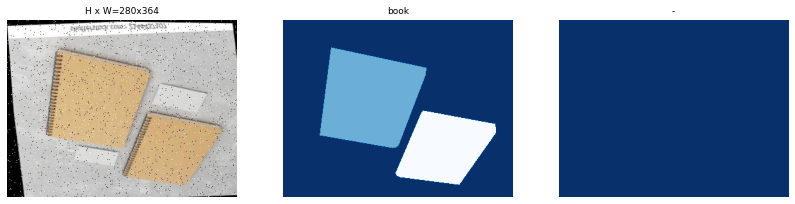

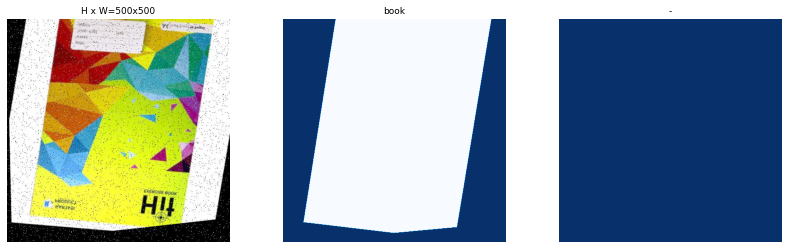

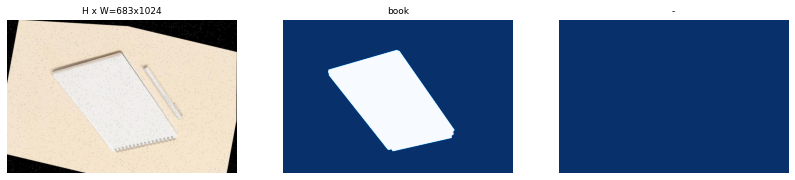

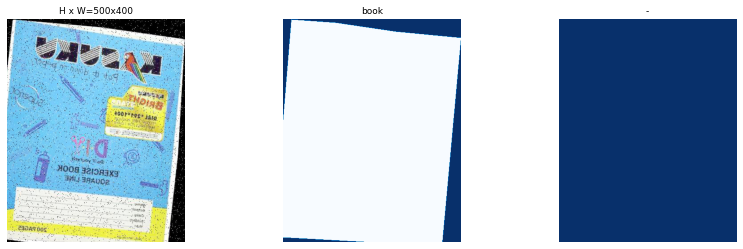

ValueError: ignored

In [ ]:
dataset = dataset_train
image_ids = dataset.image_ids

count_correct = 0;
counterr = 0;

image_correct= [];
imageerr = [];

for image_id in image_ids:
  # print(image_id)
  # try:
      image = dataset.load_image(image_id)
      mask, class_ids = dataset.load_mask(image_id)
      display_top_masks(image, mask, class_ids, dataset.class_names, limit=2)
      count_correct += 1
      image_correct. append(image_id)
  # except:
  #     # print(image_id)
  #     counterr += 1
  #     imageerr.append(image_id)
  #     continue

In [ ]:
print("Correct Images", image_correct)
print("Count Correct", count_correct)

print("Error Images: ", imageerr)
print("Count Error: ", counterr)

Correct Images [0, 3, 7, 9, 12, 13, 19, 20, 21, 22, 24, 25]
Count Correct 12
Error Images:  [1, 2, 4, 5, 6, 8, 10, 11, 14, 15, 16, 17, 18, 23, 26]
Count Error:  15


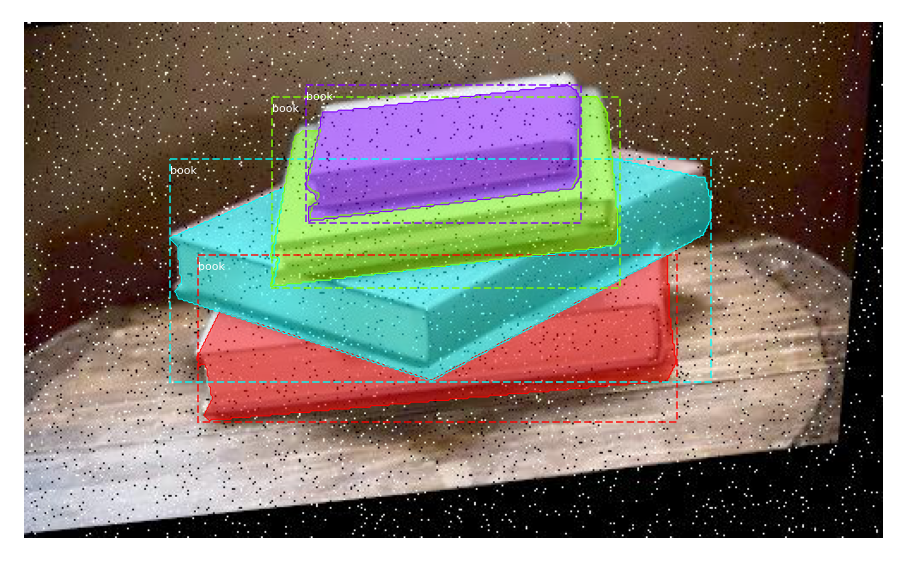

In [ ]:
# define image id
image_id = 56
try:
  # load the image
  image = dataset_train.load_image(image_id)
  # load the masks and the class ids
  mask, class_ids = dataset_train.load_mask(image_id)

  # extract bounding boxes from the masks
  bbox = extract_bboxes(mask)
  # display image with masks and bounding boxes
  display_instances(image, bbox, mask, class_ids, dataset_train.class_names)
except:
  print(image_id)


In [ ]:
# Defining a configuration for the model
class  ObjectsConfig(Config):
  # define the name of the configuration
  NAME = "object_cfg"
  # number of classes (books)
  NUM_CLASSES = 1 + 1
  # number of training steps per epoch
  STEPS_PER_EPOCH = 100
  # DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence

# prepare config
config = ObjectsConfig()
config.display

<bound method Config.display of <__main__.ObjectsConfig object at 0x7f89db93c890>>

In [ ]:
# Storage of log files, weights and model during training
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR) # To find local version o the library
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "model/logs")
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [ ]:
# Define the model
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
# load weights (mscoco) ans exclude output layers
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=25, layers='heads')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead



Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/repos/Mask_RCNN/model/logs/object_cfg20221109T1239/mask_rcnn_object_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4    

Instructions for updating:
Use tf.cast instead.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/25


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

KeyboardInterrupt: ignored